# Experimento: A "Folha de Borracha" e a Geometria Exata
## Mapeamento de Autovetores vs Vetores Comuns

Neste experimento, aplicaremos o conceito da "folha de borracha" utilizando um mapeamento de coordenadas estritamente Cartesiano sobre a imagem da Mona Lisa.

Para provar visualmente a definição matemática de que um autovetor **não muda de direção**, faremos o seguinte:
1. **Setas Vermelhas (Autovetores):** Devem apenas esticar ou encolher, mantendo a direção original. O círculo na ponta repousará sobre o *exato mesmo detalhe* da pintura antes e depois.
2. **Setas Azuis (Vetores Comuns):** Representam vetores aleatórios. Durante a deformação, eles **mudarão de direção** (rotacionarão) em relação à pintura.

Para fins didáticos, projetamos uma matriz cuja deformação direciona um dos autovetores cirurgicamente para o rosto da Mona Lisa.

In [22]:
import os
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from typing import Tuple, Optional

# Semente para reprodutibilidade
np.random.seed(28)

# Paleta de cores didática (Padrão GRAN)
COR_AZUL_PRINCIPAL = "#0D134C" # Vetores comuns (que mudam de direção)
COR_VERMELHO = "#DD303E"       # Autovetores (que mantêm a direção)
COR_BRANCO = "#FFFFFF"

# URL da Mona Lisa (Wikimedia Commons)
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/402px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"
IMAGE_PATH_LOCAL = "../data/mona_lisa_sample.jpg"

def carregar_imagem(url: str, local_path: str) -> Optional[np.ndarray]:
    """Lê a imagem local ou faz o download seguro se não existir."""
    if os.path.exists(local_path):
        return np.array(Image.open(local_path).convert('L'))
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        img_pil = Image.open(BytesIO(response.content)).convert('L')
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        img_pil.save(local_path)
        return np.array(img_pil)
    except Exception as e:
        print(f"Erro ao obter imagem: {e}\nBaixe manualmente '{url}' e salve como '{local_path}'.")
        raise FileNotFoundError("Imagem não encontrada.")

try:
    img_array = carregar_imagem(IMAGE_URL, IMAGE_PATH_LOCAL)
    print(f"Imagem carregada. Dimensões: {img_array.shape}")
except FileNotFoundError:
    pass

Imagem carregada. Dimensões: (599, 402)


## 1. Definindo a Matriz Direcionada

Desenhamos uma matriz simétrica específica que irá esmagar o espaço ligeiramente e esticá-lo em direção ao rosto da Mona Lisa.

$$A = \begin{bmatrix} 1.1 & -0.2 \\ -0.2 & 1.4 \end{bmatrix}$$

In [23]:
# Matriz A no espaço Cartesiano (X, Y)
A = np.array([
    [1.1, -0.2],
    [-0.2, 1.4]
])

# Calcular autovalores e autovetores matematicamente
evals, evecs = np.linalg.eig(A)

print("Análise Matemática da Matriz de Transformação:")
for i in range(2):
    print(f"Autovetor {i+1}: {evecs[:, i].round(3)} | Autovalor (λ): {evals[i]:.2f}")
    if evals[i] > 1:
        print("  -> O espaço será ESTICADO ao longo desta linha.\n")
    else:
        print("  -> O espaço permanecerá do MESMO TAMANHO ao longo desta linha.\n")

Análise Matemática da Matriz de Transformação:
Autovetor 1: [-0.894 -0.447] | Autovalor (λ): 1.00
  -> O espaço permanecerá do MESMO TAMANHO ao longo desta linha.

Autovetor 2: [ 0.447 -0.894] | Autovalor (λ): 1.50
  -> O espaço será ESTICADO ao longo desta linha.



## 2. O Motor de Deformação Cartesiana (Warping)

Mapeamos cada ponto $(X, Y)$ da imagem final multiplicando por $A^{-1}$ para saber de qual ponto $(X_{orig}, Y_{orig})$ da imagem inicial ele "puxou" a cor, centralizando a origem `(0,0)` exatamente no peito da pintura.

In [24]:
def transformar_imagem_cartesiana(img: np.ndarray, matriz: np.ndarray) -> Tuple[np.ndarray, Tuple[float, float, float, float]]:
    """
    Aplica a transformação linear considerando o centro da imagem como (0,0) 
    e o eixo Y crescendo para cima.
    """
    H, W = img.shape
    A_inv = np.linalg.inv(matriz)
    
    # 1. Definir os limites do espaço final para a imagem não ser cortada
    corners = np.array([[-W/2, -H/2], [W/2, -H/2], [-W/2, H/2], [W/2, H/2]])
    new_corners = corners @ matriz.T
    min_x, max_x = new_corners[:, 0].min(), new_corners[:, 0].max()
    min_y, max_y = new_corners[:, 1].min(), new_corners[:, 1].max()
    out_W, out_H = int(np.ceil(max_x - min_x)), int(np.ceil(max_y - min_y))
    
    # 2. Criar a Malha Cartesiana de destino (Y decresce refletindo a matriz da imagem)
    X, Y = np.meshgrid(np.linspace(min_x, max_x, out_W), np.linspace(max_y, min_y, out_H))
    
    # 3. Aplicar A^{-1} para encontrar as coordenadas originais
    orig_coords_flat = A_inv @ np.vstack((X.flatten(), Y.flatten()))
    
    # 4. Converter coordenadas Cartesianas de volta para índices (row, col)
    cols = orig_coords_flat[0, :] + W/2
    rows = H/2 - orig_coords_flat[1, :] 
    
    # 5. Interpolar as cores
    img_transformada = ndimage.map_coordinates(img, np.vstack((rows, cols)), order=3, cval=255)
    img_transformada = img_transformada.reshape((out_H, out_W))
    
    extent_out = (min_x, max_x, min_y, max_y)
    return img_transformada, extent_out

# Executa a transformação
img_transf, extent_transf = transformar_imagem_cartesiana(img_array, A)
extent_orig = (-img_array.shape[1]/2, img_array.shape[1]/2, -img_array.shape[0]/2, img_array.shape[0]/2)

## 3. A Prova Visual

Observe o comportamento distinto das setas:
* **Vermelhas (Autovetores):** Um aponta diretamente para o rosto e o outro para o horizonte. Note que na imagem transformada eles **não saíram do lugar** em relação à pintura. Eles apenas sofreram ação da escala ($\lambda$).
* **Azuis (Vetores Comuns):** Inserimos vetores comuns apontando para cima e para a direita. Na imagem original, eles apontam para o pescoço e para o braço esquerdo. Na imagem transformada, eles **escorregam pela pintura e mudam de direção**, provando que não são autovetores.

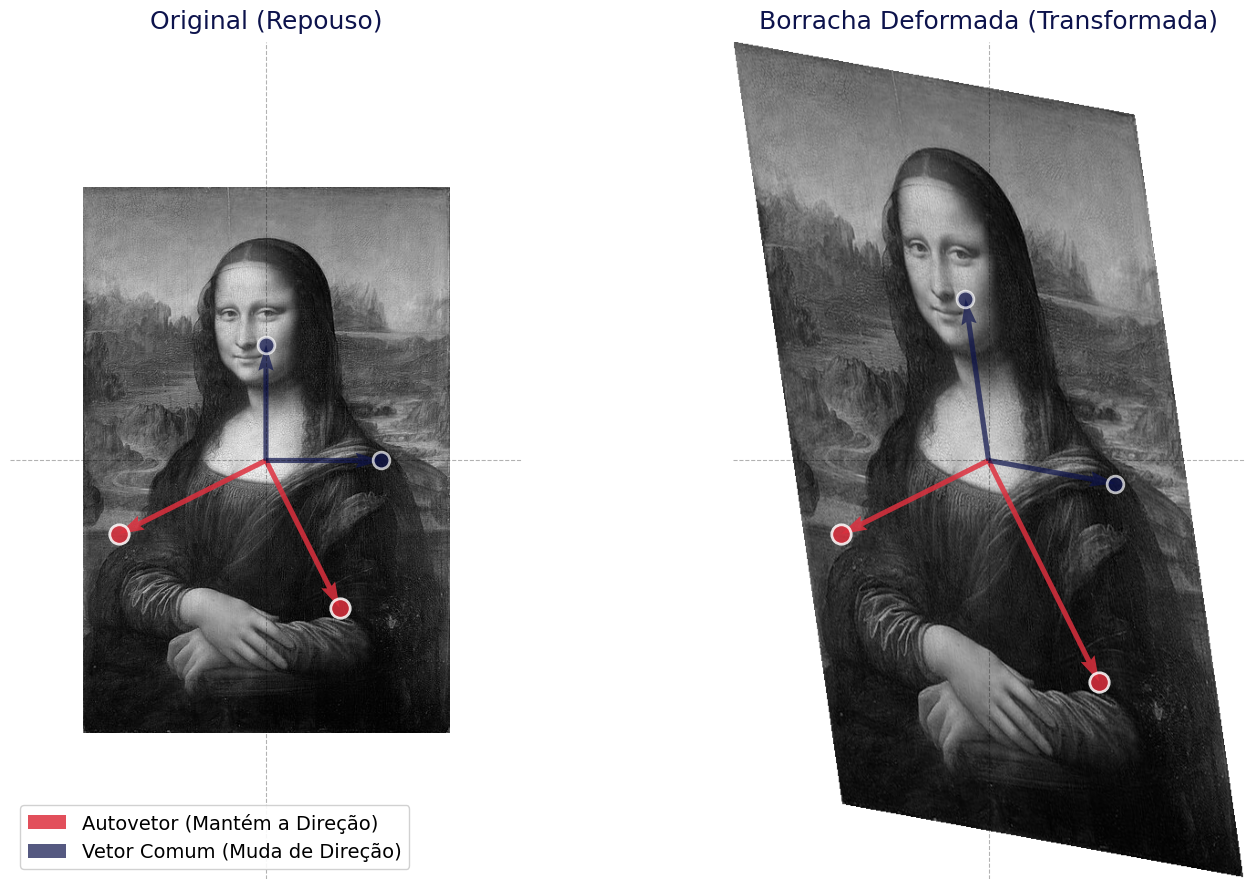

In [28]:
def plotar_prova_autovetores(img_orig, ext_orig, img_trans, ext_trans, val, vec, matrix_A):
    fig, axes = plt.subplots(1, 2, figsize=(16, 9), facecolor=COR_BRANCO)
    
    axes[0].imshow(img_orig, cmap='gray', extent=ext_orig)
    axes[1].imshow(img_trans, cmap='gray', extent=ext_trans)
    axes[0].set_title("Original (Repouso)", fontsize=18, color=COR_AZUL_PRINCIPAL, pad=10)
    axes[1].set_title("Borracha Deformada (Transformada)", fontsize=18, color=COR_AZUL_PRINCIPAL, pad=10)
    
    # Comprimento base das setas ajustado para mirar o rosto
    C = ext_orig[1] * 0.90 
    
    # Vetores Comuns (Não-Autovetores): Eixos X e Y
    non_evecs = np.array([[1.0, 0.0], 
                          [0.0, 1.0]])
    
    for ax, is_transf in zip(axes, [False, True]):
        ax.axhline(0, color='black', linewidth=0.8, alpha=0.3, ls='--')
        ax.axvline(0, color='black', linewidth=0.8, alpha=0.3, ls='--')
        ax.axis('off')
        
        # 1. Plotar Autovetores (VERMELHO - Mantém Direção)
        for i in range(2):
            v_x, v_y = vec[0, i], vec[1, i]
            p_orig = np.array([C * v_x, C * v_y])
            
            # Autovetores apenas multiplicam pelo autovalor
            p_final = p_orig * val[i] if is_transf else p_orig
            
            ax.quiver(0, 0, p_final[0], p_final[1], angles='xy', scale_units='xy', scale=1, 
                      color=COR_VERMELHO, width=0.010, alpha=0.85,
                      label="Autovetor (Mantém a Direção)" if i==0 and not is_transf else "")
            
            # Ponto de ancoragem
            ax.plot(p_final[0], p_final[1], marker='o', markersize=14, color=COR_VERMELHO, 
                    markeredgecolor=COR_BRANCO, markeredgewidth=2, alpha=0.85)
            
        # 2. Plotar Vetores Comuns (AZUL - Mudam Direção)
        for i in range(2):
            v_x, v_y = non_evecs[0, i], non_evecs[1, i]
            p_orig = np.array([C * 0.7 * v_x, C * 0.7 * v_y]) # Um pouco mais curtos
            
            # Vetores comuns são multiplicados pela Matriz A (Rotacionam e Escalam)
            p_final = matrix_A @ p_orig if is_transf else p_orig
            
            ax.quiver(0, 0, p_final[0], p_final[1], angles='xy', scale_units='xy', scale=1, 
                      color=COR_AZUL_PRINCIPAL, width=0.010, alpha=0.7,
                      label="Vetor Comum (Muda de Direção)" if i==0 and not is_transf else "")
            
            # Ponto de ancoragem
            ax.plot(p_final[0], p_final[1], marker='o', markersize=12, color=COR_AZUL_PRINCIPAL, 
                    markeredgecolor=COR_BRANCO, markeredgewidth=2, alpha=0.7)

        ax.set_xlim(ext_trans[0], ext_trans[1])
        ax.set_ylim(ext_trans[2], ext_trans[3])
        if not is_transf:
            ax.legend(loc='lower left', fontsize=14, framealpha=0.9)

    plt.tight_layout()
    output_path = os.path.join("..", "outputs", "figures", "aula_05", "mona_lisa_autovetores_vs_comuns.jpg")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=200)
    plt.show()

plotar_prova_autovetores(img_array, extent_orig, img_transf, extent_transf, evals, evecs, A)